To analyse trend, we are gonna get rid of noise from data.

In [1]:
!pip install yahoo-finance

Cleaning up...


In [2]:
from yahoo_finance import Share
yahoo = Share("YHOO")

hist_data = yahoo.get_historical(start_date="2015-03-01", end_date="2016-04-01")


In [6]:
def get_data_by_key(data, key):
    data_key = []
    for x in iter(data):
        data_key.append(x[key])
    return data_key

In [64]:
op = np.array(get_data_by_key(hist_data, 'Open'), dtype="float")

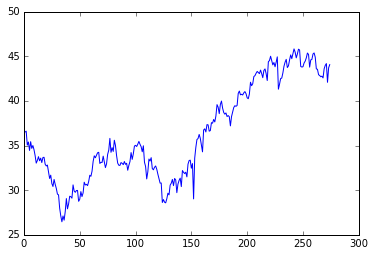

In [91]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(op)

Using treand model, we smooth data.

In [225]:
import numpy as np

class TrendModel(object):
    
    @staticmethod
    def filtering(data, dim=2):
        #dim is the dimention of trend model
        #make data for analysis
        data_list = []
        data_def = np.array(data)
        data_list.append(data_def)
        for i in xrange(dim):
            data_def = data_def[1:] - data_def[:-1]
            data_list.append(data_def)
            
        #reshape data for available
        N_data = len(data_list[-1])
        for i in xrange(len(data_list)):
            data_list[i] = data_list[i][-N_data:]
        
        #matrix for state space model 
        #x = Fx + Gv
        #y = Hx + w
        #Q, R is variance matrix for v, w respectively
        F = np.tri(dim + 1).T
        G = np.tri(dim + 1).T
        R = 1.0*np.identity(dim + 1)
        Q = 1.0e-5*np.identity(dim + 1)
        x_data = np.array(data_list).T
        
        #filtering step
        V_pred_data = []
        V_filt_data = []
        x_pred_data = []
        x_filt_data = []
        x_filt = x_data[0]
        x_filt_data.append(x_filt)
        V_filt = R
        V_filt_data.append(V_filt)
        for x in iter(x_data[1:]):
            x_pred = np.dot(F, x_filt)
            V_pred = np.dot(F, np.dot(V_filt, F.T)) + np.dot(G, np.dot(Q, G.T))
            kal_gain = np.dot(V_pred, np.linalg.inv(V_pred + R))
            x_filt = x_pred + np.dot(kal_gain, x - x_pred)
            V_filt = np.dot(np.identity(dim + 1) - kal_gain, V_pred)
            #store data for smoothing
            x_pred_data.append(x_pred)
            V_pred_data.append(V_pred)
            x_filt_data.append(x_filt)
            V_filt_data.append(V_filt)
            
        #smoothing step
        N_pred_data = len(V_pred_data)
        x_sm_data = []
        V_sm_data = []
        x_sm = x_filt_data[-1]
        x_sm_data.append(x_sm[0])
        V_sm = V_filt_data[-1]
        V_sm_data.append(V_sm)
        for i in xrange(N_pred_data):
            idx = N_pred_data - i - 1
            smoother = np.dot(V_filt_data[idx], np.dot(F.T, np.linalg.inv(V_pred_data[idx])))
            x_sm = x_filt_data[idx] + np.dot(smoother, x_sm - x_pred_data[idx])
            V_sm = V_filt_data[idx] + np.dot(smoother, np.dot(V_sm - V_pred_data[idx], smoother.T))
            x_sm_data.append(x_sm[0])
            V_sm_data.append(V_sm[0][0])
            
        x_sm_data.reverse()
        V_sm_data.reverse()
        
        return x_sm_data, V_sm_data
    
            
            


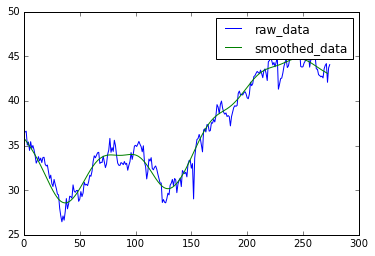

In [233]:
test = TrendModel()
x_data, V_data = test.filtering(op, dim=2)
plt.plot(op, label="raw_data")
plt.plot(x_data, label="smoothed_data")
plt.legend()

Let's implement more simple models and see difference.

In [220]:
import numpy as np
from math import factorial

class TrendModel2(object):
    
    @staticmethod
    def comb(n, r):
        assert n > 0 and r >= 0, "n should be positive integer, r should be non-negative integer"
        assert isinstance(n, int) and isinstance(r, int), "n and r should be integers"
        assert n >= r, "n>=r"
        return factorial(n)/(factorial(r) * factorial(n - r))
    
    def filtering(self, data, dim):
        #dim is the dimention of trend model
        #make data for analysis
        data_list = []
        for i in xrange(dim + 1):
            data_list.append(data[i:])
            
        #reshape data for available
        N_data = len(data_list[-1])
        for i in xrange(len(data_list)):
            data_list[i] = data_list[i][-N_data:]
        
        #matrix for state space model 
        #x = Fx + Gv
        #y = Hx + w
        #Q, R is variance matrix for v, w respectively
        F = np.zeros(shape=(dim + 1, dim + 1))
        for i in xrange(dim + 1):
            F[0][i] = self.comb(dim + 1, i + 1) * (-1)**(i)
        for i in xrange(1, dim + 1):
            F[i][i - 1] = 1.0
        G = np.zeros(shape=(dim + 1, dim + 1))
        G[0][0] = 1.0
        R = 1.0*np.identity(dim + 1)
        Q = 1.0e-5*np.identity(dim + 1)
        x_data = np.array(data_list).T
        
        #filtering step
        V_pred_data = []
        V_filt_data = []
        x_pred_data = []
        x_filt_data = []
        x_filt = x_data[0]
        x_filt_data.append(x_filt)
        V_filt = R
        V_filt_data.append(V_filt)
        for x in iter(x_data[1:]):
            x_pred = np.dot(F, x_filt)
            V_pred = np.dot(F, np.dot(V_filt, F.T)) + np.dot(G, np.dot(Q, G.T))
            kal_gain = np.dot(V_pred, np.linalg.inv(V_pred + R))
            x_filt = x_pred + np.dot(kal_gain, x - x_pred)
            V_filt = np.dot(np.identity(dim + 1) - kal_gain, V_pred)
            #store data for smoothing
            x_pred_data.append(x_pred)
            V_pred_data.append(V_pred)
            x_filt_data.append(x_filt)
            V_filt_data.append(V_filt)
            
        #smoothing step
        N_pred_data = len(V_pred_data)
        x_sm_data = []
        V_sm_data = []
        x_sm = x_filt_data[-1]
        x_sm_data.append(x_sm[0])
        V_sm = V_filt_data[-1]
        V_sm_data.append(V_sm)
        for i in xrange(N_pred_data):
            idx = N_pred_data - i - 1
            smoother = np.dot(V_filt_data[idx], np.dot(F.T, np.linalg.inv(V_pred_data[idx])))
            x_sm = x_filt_data[idx] + np.dot(smoother, x_sm - x_pred_data[idx])
            V_sm = V_filt_data[idx] + np.dot(smoother, np.dot(V_sm - V_pred_data[idx], smoother.T))
            x_sm_data.append(x_sm[0])
            V_sm_data.append(V_sm[0][0])
            
        x_sm_data.reverse()
        V_sm_data.reverse()
        
        return x_sm_data, V_sm_data
    
            
       

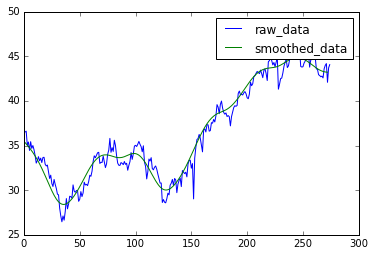

In [234]:
test = TrendModel2()
x_data, V_data = test.filtering(op, dim=2)
plt.plot(op, label="raw_data")
plt.plot(x_data, label="smoothed_data")
plt.legend()

They look the same. 

How noisy smoothed data is depends on the ratio of system noise and observation noise in the state model you use. 

Let's see how they will deffer depending on the ratio!

In [248]:

class TrendModel3(object):
    
    @staticmethod
    def filtering(data, dim, sig_ob=1.0, sig_sys=1.0):
        #dim is the dimention of trend model
        #make data for analysis
        data_list = []
        data_def = np.array(data)
        data_list.append(data_def)
        for i in xrange(dim):
            data_def = data_def[1:] - data_def[:-1]
            data_list.append(data_def)
            
        #reshape data for available
        N_data = len(data_list[-1])
        for i in xrange(len(data_list)):
            data_list[i] = data_list[i][-N_data:]
        
        #matrix for state space model 
        #x = Fx + Gv
        #y = Hx + w
        #Q, R is variance matrix for v, w respectively
        F = np.tri(dim + 1).T
        G = np.tri(dim + 1).T
        R = sig_ob**2*np.identity(dim + 1)
        Q = sig_sys**2*np.identity(dim + 1)
        x_data = np.array(data_list).T
        
        #filtering step
        V_pred_data = []
        V_filt_data = []
        x_pred_data = []
        x_filt_data = []
        x_filt = x_data[0]
        x_filt_data.append(x_filt)
        V_filt = R
        V_filt_data.append(V_filt)
        for x in iter(x_data[1:]):
            x_pred = np.dot(F, x_filt)
            V_pred = np.dot(F, np.dot(V_filt, F.T)) + np.dot(G, np.dot(Q, G.T))
            kal_gain = np.dot(V_pred, np.linalg.inv(V_pred + R))
            x_filt = x_pred + np.dot(kal_gain, x - x_pred)
            V_filt = np.dot(np.identity(dim + 1) - kal_gain, V_pred)
            #store data for smoothing
            x_pred_data.append(x_pred)
            V_pred_data.append(V_pred)
            x_filt_data.append(x_filt)
            V_filt_data.append(V_filt)
            
        #smoothing step
        N_pred_data = len(V_pred_data)
        x_sm_data = []
        V_sm_data = []
        x_sm = x_filt_data[-1]
        x_sm_data.append(x_sm[0])
        V_sm = V_filt_data[-1]
        V_sm_data.append(V_sm)
        for i in xrange(N_pred_data):
            idx = N_pred_data - i - 1
            smoother = np.dot(V_filt_data[idx], np.dot(F.T, np.linalg.inv(V_pred_data[idx])))
            x_sm = x_filt_data[idx] + np.dot(smoother, x_sm - x_pred_data[idx])
            V_sm = V_filt_data[idx] + np.dot(smoother, np.dot(V_sm - V_pred_data[idx], smoother.T))
            x_sm_data.append(x_sm[0])
            V_sm_data.append(V_sm[0][0])
            
        x_sm_data.reverse()
        V_sm_data.reverse()
        
        return x_sm_data, V_sm_data
    
            
            


# dim=2

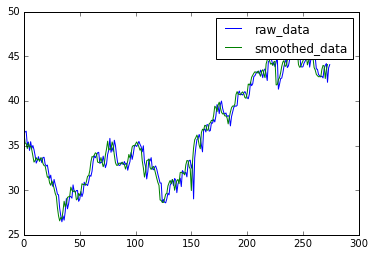

In [249]:
#sig_ob/sig_sys = 1.0

x_data, V_data = TrendModel3.filtering(op, dim=2, sig_ob=1.0, sig_sys=1.0)
plt.plot(op, label="raw_data")
plt.plot(x_data, label="smoothed_data")
plt.legend()

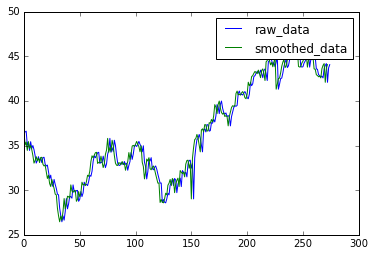

In [239]:
#sig_sys/sig_ob = 10.0

sig_ob = 1.0
sig_sys = 10.0*sig_ob
x_data, V_data = TrendModel3.filtering(op, dim=2, sig_ob=sig_ob, sig_sys=sig_sys)
plt.plot(op, label="raw_data")
plt.plot(x_data, label="smoothed_data")
plt.legend()

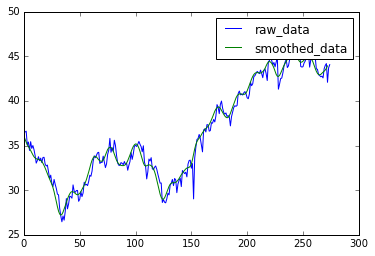

In [240]:
#sig_sys/sig_ob = 0.1

sig_ob = 1.0
sig_sys = 0.1*sig_ob
x_data, V_data = TrendModel3.filtering(op, dim=2, sig_ob=sig_ob, sig_sys=sig_sys)
plt.plot(op, label="raw_data")
plt.plot(x_data, label="smoothed_data")
plt.legend()

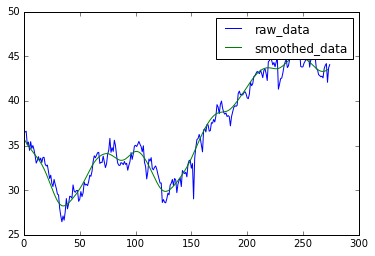

In [241]:
#sig_sys/sig_ob = 1.0e-2

sig_ob = 1.0
sig_sys = 1.0e-2*sig_ob
x_data, V_data = TrendModel3.filtering(op, dim=2, sig_ob=sig_ob, sig_sys=sig_sys)
plt.plot(op, label="raw_data")
plt.plot(x_data, label="smoothed_data")
plt.legend()

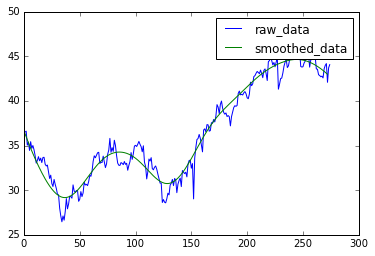

In [242]:
#sig_sys/sig_ob = 1.0e-3

sig_ob = 1.0
sig_sys = 1.0e-3*sig_ob
x_data, V_data = TrendModel3.filtering(op, dim=2, sig_ob=sig_ob, sig_sys=sig_sys)
plt.plot(op, label="raw_data")
plt.plot(x_data, label="smoothed_data")
plt.legend()

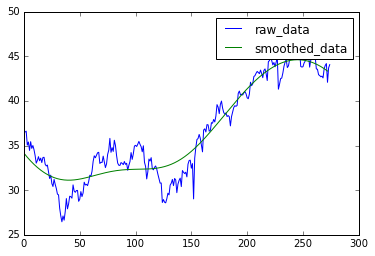

In [243]:
#sig_sys/sig_ob = 1.0e-4

sig_ob = 1.0
sig_sys = 1.0e-4*sig_ob
x_data, V_data = TrendModel3.filtering(op, dim=2, sig_ob=sig_ob, sig_sys=sig_sys)
plt.plot(op, label="raw_data")
plt.plot(x_data, label="smoothed_data")
plt.legend()

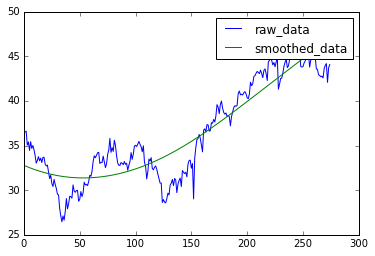

In [244]:
#sig_sys/sig_ob = 1.0e-5

sig_ob = 1.0
sig_sys = 1.0e-5*sig_ob
x_data, V_data = TrendModel3.filtering(op, dim=2, sig_ob=sig_ob, sig_sys=sig_sys)
plt.plot(op, label="raw_data")
plt.plot(x_data, label="smoothed_data")
plt.legend()

# dim=3

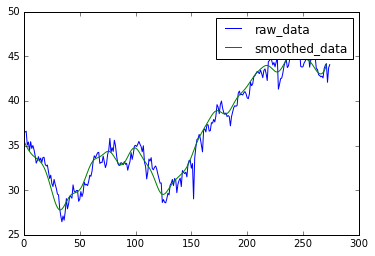

In [245]:
#sig_sys/sig_ob = 1.0e-2

sig_ob = 1.0
sig_sys = 1.0e-2*sig_ob
x_data, V_data = TrendModel3.filtering(op, dim=3, sig_ob=sig_ob, sig_sys=sig_sys)
plt.plot(op, label="raw_data")
plt.plot(x_data, label="smoothed_data")
plt.legend()

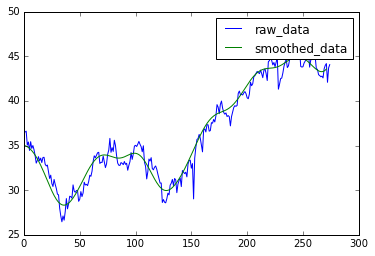

In [246]:
#sig_sys/sig_ob = 1.0e-3

sig_ob = 1.0
sig_sys = 1.0e-3*sig_ob
x_data, V_data = TrendModel3.filtering(op, dim=3, sig_ob=sig_ob, sig_sys=sig_sys)
plt.plot(op, label="raw_data")
plt.plot(x_data, label="smoothed_data")
plt.legend()

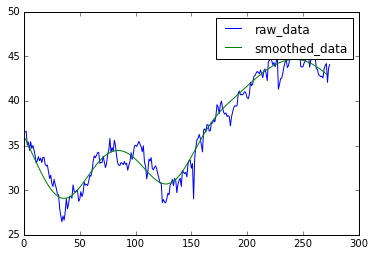

In [247]:
#sig_sys/sig_ob = 1.0e-4

sig_ob = 1.0
sig_sys = 1.0e-4*sig_ob
x_data, V_data = TrendModel3.filtering(op, dim=3, sig_ob=sig_ob, sig_sys=sig_sys)
plt.plot(op, label="raw_data")
plt.plot(x_data, label="smoothed_data")
plt.legend()